In [1]:
import numpy as np
import torch
from torchvision.utils import make_grid

from loader.MNIST_dataset import MNIST_dataset
from models.ae import AE
from models.modules import FC_image

import matplotlib.pyplot as plt

# if you don't have gpu, 
# you can set device='cpu'
device = f'cuda:0'

/home/cspark/anaconda3/envs/GM4HDDA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- In this exercise, you will study how to analyze MNIST image data that approximately lies on some low-dimensional manifold. 
- Here, we assume the manifold's dimension is 2 for visualization purpose. 
- For simplicity, we use MNIST image of digits 0, 1, 2, 3, 4


1. Load Dataset (MNIST digits 0, 1, 2, 3, 4)

- The script below automatically downloads the MNIST image data in "datasets" directory.
- The image size is (1, 28, 28) which can be viewed as a data point living in $\mathbb{R}^{784}$.

In [2]:
train_ds = MNIST_dataset(root='datasets', split='training', digits=[0, 1, 2, 3, 4])

MNIST split training | torch.Size([25525, 1, 28, 28])


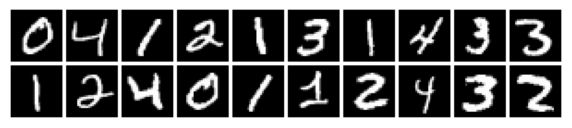

In [3]:
test_x = train_ds.data[:20]
x_img = make_grid(test_x, nrow=10, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

2. Load Pretrained Model

- You should download the pre-trained model "MNIST_digits_01234.pkl" from [HERE](https://drive.google.com/file/d/1nUB6IcvMFxEguH42ZmvamU2oY1iYHQKS/view?usp=sharing) and put it in the "pretrained/HW1/" directory. 
- The torch.nn.Module class "AE" has the two main methods "encode" and "decode", each of which corresponds to the encoder and decoder.

In [4]:
encoder = FC_image(in_chan=784, out_chan=2, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='linear') 
decoder = FC_image(in_chan=2, out_chan=784, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='sigmoid')

pretrained_model = AE(encoder, decoder)
pretrained_model.load_pretrained('pretrained/HW1/MNIST_digits_01234.pkl')
pretrained_model.to(device);

3. Visualize Embeddings

- Data points are mapped to the two-dimensioanl latent space (or coordinate space) by the encoder and visualized with label-coded colors.

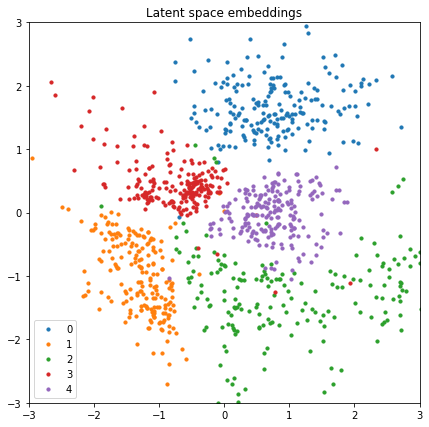

In [5]:
latent_embeddings = pretrained_model.encode(train_ds.data.to(device)).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

### Problem

(a) Write the code for computing the Riemannian metric expressed in the latent space.

In [6]:
# from tqdm import tqdm
from torch.autograd.functional import jacobian
from torch.autograd.functional import jvp
from tqdm import tqdm
import time

def jacobian_decoder_jvp_parallel(func, inputs, v=None, create_graph=True):
    batch_size, z_dim = inputs.size()
    if v is None:
        v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(inputs)
    inputs = inputs.repeat(1, z_dim).view(-1, z_dim)
    jac = (
        torch.autograd.functional.jvp(
            func, inputs, v=v, create_graph=create_graph
        )[1].view(batch_size, z_dim, -1).permute(0, 2, 1)
    )
    return jac

def get_Riemannian_metric(f, z, create_graph=False):
    '''
    f:      pretrained_model.decode
    z:      torch.tensor whose size = (n, 2)
    out:    torch.tensor whose size = (n, 2, 2)
    '''
    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################
    # jaco = jacobian(f, z, create_graph=create_graph)
    # jaco is 6D tensor with form of [batch, 1, 28, 28, batch, 2]


    # batch = z.shape[0]
    # out = []
    # z_ = z.clone().detach()
    # print(jacobian(f, z_, create_graph=create_graph).shape)
    # input()
    # # for i in tqdm(range(batch)):
    # for i in range(batch):
    #     # time.sleep(0.5)
    #     input = z_[i]
    #     # print(jacobian(f, input, create_graph=create_graph).shape)
    #     jaco_row = jacobian(f, input, create_graph=create_graph)[0, 0, :, : , :].reshape((-1, 2)) # Bottle neck here!
    #     # print(jaco_row)
    #     # input()
    #     # print(jaco_row)
    #     # input()
    #     # jaco_row.to(device)
    #     metric = torch.matmul(jaco_row.t(), jaco_row)
    #     out.append(metric)

    # out = torch.stack(out)
    # # check = torch.linalg.cholesky(out)

    J = jacobian_decoder_jvp_parallel(f, z, v=None, create_graph=create_graph)
    G = torch.einsum('nij, nik -> njk',J, J)
    
    return G

- Your function "get_Riemannian_metric" should pass the below test code.

In [7]:
num_test = 1000
test_z = torch.randn(num_test, 2).to(device)

G = get_Riemannian_metric(pretrained_model.decode, test_z)
assert (G.size() == torch.Size([num_test, 2, 2]))

rand_v = torch.randn(num_test, 2).to(device)
assert torch.einsum('ni, nij, nj -> n', rand_v, G, rand_v).min().item() > 0

- With the "get_Riemannian_metric" function that you wrote, the below code will visualize the Riemannian metrics evaluated at some randomly selected points as equidistant ellipses, where the equidistant ellipse is defined as follows: given a Riemannian metric $G(z)$ at $z$, the equidistant ellipse at $z$ is a set $\{z' \ | \ (z'-z)^T G(z) (z'-z) = c\}$ for some constant $c>0$.  

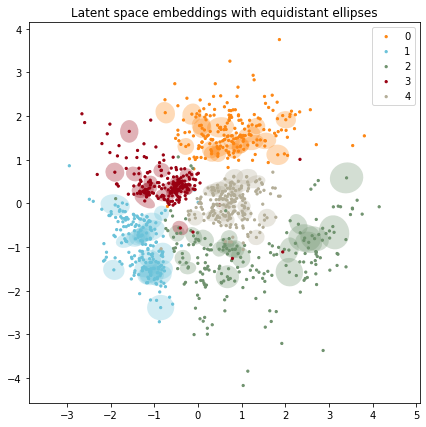

In [8]:
from utils import visualize_Riemannian_metric_as_ellipses

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
    
visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device)

Q1) Can you interpret this result?

A) More dense the data are, more smaller the equidistant ellipse gets, which means the egienvalue of G is bigger in dense region.

- Now let's select class boundary points and visualize equidistant ellipses there.

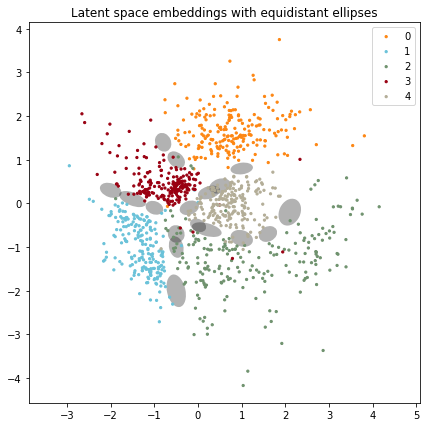

In [9]:
bd_points = torch.tensor([
    [-2, 0.3],
    [-1.5, 0.1],
    [-1, -0.1],
    [-0.5, -0.7],
    [-0.5, -1],
    [-0.5, -2],
    [0, -0.5],
    [0.2, -0.6],
    [1, -0.8],
    [1.6, -0.7],
    [2.1, -0.2],
    [-0.2, -0.1],
    [0.25, 0.25],
    [0.5, 0.4],
    [1, 0.8],
    [-0.5, 1],
    [-0.8, 1.4],
    ], dtype=torch.float32).to(device)

visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device,
    at=bd_points)

Q2) In which directions are the ellipses longer? Can you interpret this result?

A)  The axis of ellipse is longer along the criteria. This means that the egien value is smaller in the way of boundary between datas.

(b) Write the code for computing the legnth of a curve $z(t) \in \mathbb{R}^{2}$ for $t\in[0,1]$ which corresponds to a curve on the two-dimensional MNIST data manifold, by using the "get_Riemannian_metric" function.

In [10]:
def compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric):
    '''
    curve:  torch.tensor whose size = (L, 2)
    out:    torch.tensor whose size = (1)
    '''
    
    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################
    r_metric = get_Riemannian_metric(pretrained_model.decode, curve)[:-1, :]
    diff = curve[1:, :] - curve[:-1, :]
    diff.to(device)
    # diff: (L-1, 2)
    # r_metric: (L-1, 2, 2)
    ds = torch.einsum('ij, ijk, ik ->i', diff, r_metric, diff)
    ds = ds.sqrt()
    out = ds.sum()
    
    return out

- Your function should pass the below test code.

In [11]:
x1 = test_x[0:1]
x2 = test_x[1:2]

z1 = pretrained_model.encode(x1.to(device))
z2 = pretrained_model.encode(x2.to(device))

list_len = []
for num_discretization in [100, 1000]:
    z_curve = torch.cat([z1 + (z2 - z1) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    L = compute_length_of_curve(z_curve, pretrained_model, get_Riemannian_metric).item()
    list_len.append(L)
    print(f"length of {num_discretization}: {L}")
assert ((list_len[0] - list_len[1])/list_len[0] < 0.1)

length of 100: 33.88954544067383
length of 1000: 33.93567657470703


- Now, you will compare the lengths of two curves whose lengths are same in the latent space.
- Below, the red and green squares correspond to digit 2 images and the blue square corresponds to digit 4 image.

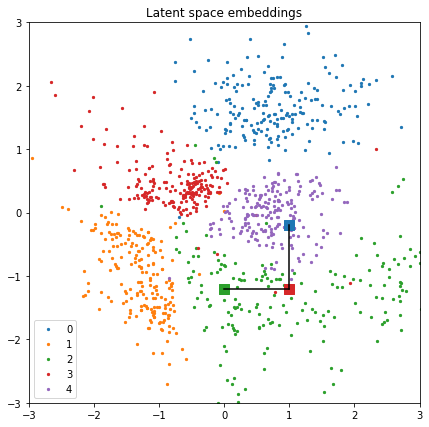

In [12]:
z1 = torch.tensor([[1, -1.2]], dtype=torch.float32) # digit 2 (red)
z2 = torch.tensor([[0, -1.2]], dtype=torch.float32) # digit 2 (green)
z3 = torch.tensor([[1, -0.2]], dtype=torch.float32) # digit 4 (blue)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s', s=100)
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s', s=100)
plt.scatter(z3[0, 0], z3[0, 1], c='tab:blue', marker='s', s=100)

plt.plot((z1[0, 0], z2[0, 0]), (z1[0, 1], z2[0, 1]), c='k')
plt.plot((z1[0, 0], z3[0, 0]), (z1[0, 1], z3[0, 1]), c='k')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

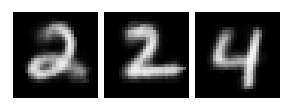

In [13]:
x1 = pretrained_model.decode(z1.to(device)) # red
x2 = pretrained_model.decode(z2.to(device)) # green 
x3 = pretrained_model.decode(z3.to(device)) # blue

x_img = make_grid(
    torch.cat([x1, x2, x3], dim=0).detach().cpu(), 
    nrow=3, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(5,5))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()


- Compute the lengths of two curves, red2green and red2blue straight lines, by using the "compute_length_of_curve" function.

In [14]:
num_discretization = 100
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
z13_linear_curve = torch.cat([z1.to(device) + (z3.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

L12 = compute_length_of_curve(
    z12_linear_curve
    , pretrained_model, get_Riemannian_metric)
L13 = compute_length_of_curve(
    z13_linear_curve
    , pretrained_model, get_Riemannian_metric)
L12, L13

(tensor(11.2820, device='cuda:0'), tensor(15.5822, device='cuda:0'))

Q3) Which curve is longer? Why?

A)  Curve connecting '2' '4' is longer. Due to the Riemannian metric the curve becomes longer than euclidean distance.

(c) Write the code for finding the geodesic curve that connects two points $z_1, z_2 \in \mathbb{R}^2$ by using your "get_Riemannian_metric" function (you may want to use some python library for optimization, e.g., scipy.optimize.minimize, and use one of the gradient-based methods for fast optimization).

In [182]:

from scipy.optimize import minimize
import numpy as np

def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    
    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################

    # def get_length(x):
    #     # print(z1.shape)
    #     # print(x.shape)
    #     # print(z2.shape)

    #     curve = torch.cat([z1, torch.tensor(x.reshape((-1, 2)), dtype=torch.float32).to(device), z2])
    #     length = compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric)

    #     return length

    #     # z1_ = z1.cpu().detach().numpy()
    #     # z2_ = z2.cpu().detach().numpy()
    #     # # print(f"z1: {z1_} \nz2: {z2_}")
    #     # x = np.concatenate((z1_, x.reshape((-1,2)), z2_), axis=0)
    #     # # print(f"x: {x}")
    #     # x = x[1:, :] - x[:-1, :]
    #     # # print(f"x: {x}")

    #     # ds_array = np.linalg.norm(x, axis=1)**2
    #     # # print(ds_array)
    #     # # print(ds_array)
    #     # # print(ds_array.sum())
        
    #     # return ds_array.sum()
    # # get_length debug
    # initial_point = np.random.rand(num_discretization - 2, 2).reshape((-1,))
    # # initial_point = np.zeros((num_discretization - 2, 2)).reshape((-1,))
    # print(f'initial_point: {initial_point.reshape((-1, 2))}')
    # # get_length(initial_point)
    
    # # print(initial_point.shape)
    # # input()
    # print('doing minimize')
    # opt_res = minimize(get_length, initial_point, method='nelder-mead', options={'xtol': 1e-3, 'disp': True})    
    # print('finished minimize')

    # intermediate_points = torch.tensor(opt_res.x.reshape((-1, 2)), device=device, dtype=torch.float32) 
    # out = torch.cat((z1, intermediate_points, z2), dim=0).to(device)
    # print(f'geodesic_curve: {out}')
     
    ### Version 2 ###
    def compute_length_of_curve_square(curve, pretrained_model, get_Riemannian_metric):
        '''
        curve:  torch.tensor whose size = (L, 2)
        out:    torch.tensor whose size = (1)
        '''
        
        ##############################################
        ############### YOUR CODE HERE ###############
        ##############################################
        r_metric = get_Riemannian_metric(pretrained_model.decode, curve)[:-1, :]
        diff = curve[1:, :] - curve[:-1, :]
        diff.to(device)
        # diff: (L-1, 2)
        # r_metric: (L-1, 2, 2)
        ds = torch.einsum('ij, ijk, ik ->i', diff, r_metric, diff)
        out = ds.sum()
        
        return out
    def get_length(x):

        curve = torch.cat([z1, x.reshape(-1, 2), z2])
        length = compute_length_of_curve_square(curve, pretrained_model, get_Riemannian_metric)

        return length

    # x = torch.rand(2*num_discretization, device=device, requires_grad=True)
    x = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * (t+1)/(num_discretization-1) for t in range(num_discretization-2)], dim=0).reshape(-1)
    x = x.clone().detach().requires_grad_(True)
    print(x.shape)
    print(x.is_leaf)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([x], lr=0.01)
    # optimizer = torch.optim.SGD([x], lr=0.00001)

    num_timestep = 15000
    zero = torch.tensor([0], dtype=torch.float32).to(device)
    for i in range(num_timestep):
        length = get_length(x)
        length = length.unsqueeze(0)
        # print(f"{i}th itr length: {length}")
        loss = loss_fn(length, zero)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(f"{i}th itr loss: {loss.item()}")
    
    optx = x.clone().detach().reshape(-1, 2)
    optx = torch.cat([z1, optx, z2], dim=0)
    print(optx.shape)
    return optx

    #### Version 3 ####

    # def get_length_pytorch(curve):
    #     curve = torch.cat([z1, curve, z2], dim=0)
    #     return compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric)

    # def get_length_pytorch(z_via):
    #     curve = torch.cat((z1, z_via, z2), dim=0)
    #     curve_dz = curve[1:, :] - curve[:-1, :]                                       # size = (L-1, 2), z_i+1 - z_i
    #     curve_midpts = 0.5 * (curve[1:, :] + curve[:-1, :])                           # size = (L-1, 2), (1/2)*(z_i+1 + z_i)
    #     G_midpts = get_Riemannian_metric(pretrained_model.decode, curve_midpts)       # size = (L-1, 2, 2), G(z_i)
    #     dl = torch.einsum('ij, ijk, ik -> i', curve_dz, G_midpts, curve_dz)
    #     loss = dl.sum()
    #     return loss

    # def get_length(curve):
    #     curve = torch.from_numpy(curve).to(device).reshape(num_discretization-2, 2).float()
    #     length = get_length_pytorch(curve)
    #     length = length.detach().cpu().numpy().astype(np.float32).squeeze().flatten()
    #     return length

    # def get_length_grad_torch(curve):
    #     grad = torch.autograd.functional.jacobian(get_length_pytorch, curve, create_graph=False)
    #     return grad

    # def get_length_grad(curve):
    #     curve = torch.from_numpy(curve).to(device).reshape(num_discretization-2, 2).float()
    #     grad = get_length_grad_torch(curve)
    #     grad = grad.detach().cpu().numpy().astype(np.float32).squeeze().flatten()
    #     return grad
    
    # x = torch.cat([z1 + (z2 - z1) * t/(num_discretization-1) for t in range(1,num_discretization-1)], dim=0)
    # x = x.detach().cpu().numpy().astype(np.float32).reshape((-1))
    # x_sol = minimize(get_length, x0=x, method='BFGS', jac=get_length_grad).x
    # x_sol = torch.from_numpy(x_sol).reshape(num_discretization-2, 2).to(device).float()
    # geodesic = torch.cat([z1, x_sol, z2], dim=0)

    # return geodesic

    

- Your code should pass the below test code.

In [183]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])

torch.Size([196])
True
torch.Size([100, 2])


- Compute the lengths of the geodesic curve (i.e., geodesic distances).

In [184]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12

tensor(33.8633, device='cuda:0')

- Let's compare the geodesic and linear interpolation results.
- The gray line is the linear interpolation in the latent space and the pink line is the geodesic interpolation. 

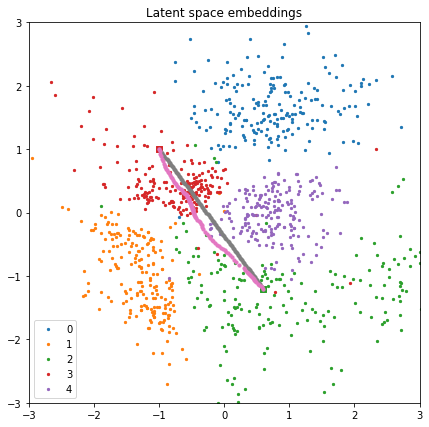

In [186]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

# plt.plot(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), '-o', c='tab:gray')
# plt.plot(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(),'-o', c='tab:pink')
plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

- Below visualizes the corresponding sequences of images.

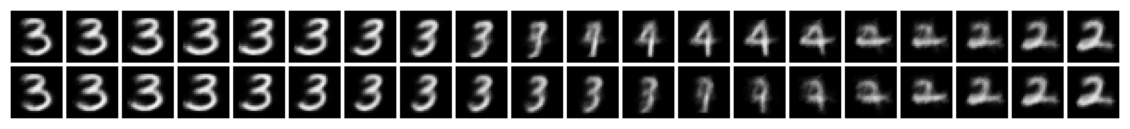

In [187]:
x12_linear_curve = pretrained_model.decode(z12_linear_curve)
x12_geodesic_curve = pretrained_model.decode(z12_geodesic_curve)

x_img = make_grid(
    torch.cat([
        x12_linear_curve[0:-1:5], 
        x12_geodesic_curve[0:-1:5]], dim=0).detach().cpu(), 
    nrow=20, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(20,20))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

Q4) How are they different? Why?

A) Euclidian curve passes the region where the number is '4'. On the other hand, Riemannian geodesics minizies crossing between classes which makes the curve go directly to '2' without passing other classes.

- Lastly, you will implement a clustering algorithm by using the geodesic distances and compare it with a usal Euclidean distance-based clustering algorithm in the latent sapce.
- We will use the SpectralClustering algorithm and only consider a subset of digit 2 and 4 images for simplicity. 

In [113]:
latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu()
data = []
targets = []
labels = [2, 4]

num_for_each_class = 20
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    data.append(classwise_le[:num_for_each_class])
    targets.append(train_ds.targets[train_ds.targets == label][:num_for_each_class])
data = torch.cat(data, dim=0)
targets = torch.cat(targets, dim=0)

In [114]:
from sklearn.cluster import SpectralClustering

## Euclidean clustering
SC = SpectralClustering(n_clusters=2)
SC.fit(data)
Euclidean_est = torch.tensor(SC.labels_)

## Geodesic clustering
num_data = len(data)
tau = 10000
affinity_matrix = np.eye(num_data)
for i in range(num_data):
    for j in range(i+1, num_data):
        z1 = data[i:i+1]
        z2 = data[j:j+1]
        z12_geodesic_curve = compute_geodesic(
            z1.to(device), 
            z2.to(device), 
            pretrained_model, 
            get_Riemannian_metric, 
            num_discretization=100)
        dist = compute_length_of_curve(
            z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
        affinity_matrix[i, j] = 2 * np.exp(-dist.item()**2/tau) 
        print(f'{i}-{j} done') 

affinity_matrix = (affinity_matrix + affinity_matrix.transpose())/2
SC = SpectralClustering(n_clusters=2, affinity='precomputed')
SC.fit(affinity_matrix)
Geodesic_est = torch.tensor(SC.labels_)

0-1 done
0-2 done
0-3 done
0-4 done
0-5 done
0-6 done
0-7 done
0-8 done
0-9 done
0-10 done
0-11 done
0-12 done
0-13 done
0-14 done
0-15 done
0-16 done
0-17 done
0-18 done
0-19 done
0-20 done
0-21 done
0-22 done
0-23 done
0-24 done
0-25 done
0-26 done
0-27 done
0-28 done
0-29 done
0-30 done
0-31 done
0-32 done
0-33 done
0-34 done
0-35 done
0-36 done
0-37 done
0-38 done
0-39 done
1-2 done
1-3 done
1-4 done
1-5 done
1-6 done
1-7 done
1-8 done
1-9 done
1-10 done
1-11 done
1-12 done
1-13 done
1-14 done
1-15 done
1-16 done
1-17 done
1-18 done
1-19 done
1-20 done
1-21 done
1-22 done
1-23 done
1-24 done
1-25 done
1-26 done
1-27 done
1-28 done
1-29 done
1-30 done
1-31 done
1-32 done
1-33 done
1-34 done
1-35 done
1-36 done
1-37 done
1-38 done
1-39 done
2-3 done
2-4 done
2-5 done
2-6 done
2-7 done
2-8 done
2-9 done
2-10 done
2-11 done
2-12 done
2-13 done
2-14 done
2-15 done
2-16 done
2-17 done
2-18 done
2-19 done
2-20 done
2-21 done
2-22 done
2-23 done
2-24 done
2-25 done
2-26 done
2-27 done
2-28

Text(0.5, 1.0, 'Geodesic clustering result')

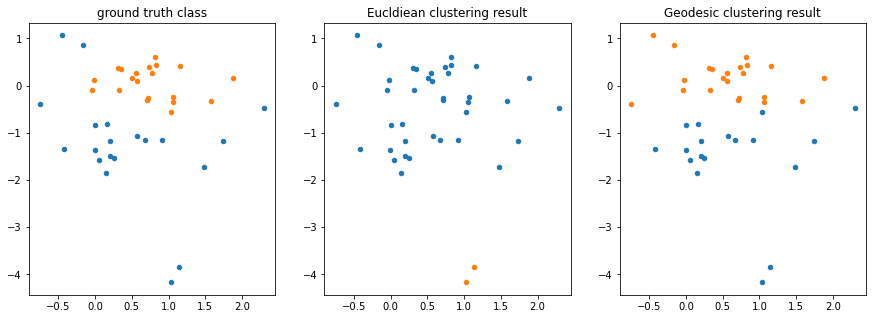

In [115]:
## plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for label in labels:
    classwise_le = data[targets == label]
    axes[0].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[0].set_title('ground truth class')

for label in [0, 1]:
    classwise_le = data[Euclidean_est == label]
    axes[1].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[1].set_title('Eucldiean clustering result')

for label in [0, 1]:
    classwise_le = data[Geodesic_est == label]
    axes[2].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[2].set_title('Geodesic clustering result')

Q5) Compare the results.

A) We can observe better clustering performance when using Riemannian metric. Riemannian metric measures the distance in boundary longer which makes the spectral clustering algorithm to classify better on the boundaries.

- To see more experiemnt results by using the latent space Riemannian metric, e.g., clustering with geodesic distances, chcek out the paper ["Latent Space Oddity: on the Curvature of Deep Generative Models"](https://arxiv.org/abs/1710.11379).